In [ ]:
import os
os.listdir('/kaggle/input')


['hr-200-subset']

In [ ]:
os.listdir('/kaggle/input/hr-200-subset')


['train_hr_200']

In [ ]:
HR_DIR = "/kaggle/input/hr-200-subset"


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [ ]:
HR_DIR = "/kaggle/input/hr-200-subset/train_hr_200"
LR_DIR = "/kaggle/working/DIV2K_LR_X4"
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4

In [ ]:
os.makedirs(LR_DIR, exist_ok=True)

def create_lr_image(hr_path, lr_path):
    """Create LR image with more realistic degradation"""
    img = cv2.imread(hr_path)
    if img is None:
        return False

    # gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 1.0)

    # Downscale 4x
    h, w = img.shape[:2]
    small = cv2.resize(blurred, (w//4, h//4), interpolation=cv2.INTER_AREA)

    # Upscale back with bicubic interpolation
    upscaled = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)

    # Add slight noise
    noise = np.random.normal(0, 2, upscaled.shape).astype(np.uint8)
    upscaled = np.clip(upscaled.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    cv2.imwrite(lr_path, upscaled)
    return True

In [ ]:
for fname in os.listdir(HR_DIR):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        hr_path = os.path.join(HR_DIR, fname)
        lr_path = os.path.join(LR_DIR, fname)
        create_lr_image(hr_path, lr_path)

print(f"Generated {len(os.listdir(LR_DIR))} LR images")


Generated 200 LR images


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual

class TeacherCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.ReLU(inplace=True)
        )

        # Multiple residual blocks for better feature learning
        self.res_blocks = nn.Sequential(*[ResBlock(64) for _ in range(6)])

        self.upconv = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1)
        )

    def forward(self, x):
        feat = self.initial(x)
        feat = self.res_blocks(feat)
        out = self.upconv(feat)
        return out

class StudentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3),
            nn.ReLU(inplace=True)
        )

        # Fewer but still effective residual blocks
        self.res_blocks = nn.Sequential(*[ResBlock(32) for _ in range(3)])

        self.upconv = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, 3, padding=1)
        )

    def forward(self, x):
        feat = self.initial(x)
        feat = self.res_blocks(feat)
        out = self.upconv(feat)
        return out


In [ ]:
class SharpeningDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, img_size=128):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.img_size = img_size
        self.filenames = [f for f in os.listdir(hr_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        lr_img = Image.open(os.path.join(self.lr_dir, fname)).convert("RGB")
        hr_img = Image.open(os.path.join(self.hr_dir, fname)).convert("RGB")

        lr_tensor = self.transform(lr_img)
        hr_tensor = self.transform(hr_img)

        return lr_tensor, hr_tensor


In [ ]:
def train_teacher(teacher, dataloader, epochs=10):
    """Train teacher model on ground truth"""
    print("Training Teacher Model...")
    teacher.train()
    optimizer = optim.Adam(teacher.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for i, (lr_batch, hr_batch) in enumerate(dataloader):
            lr_batch, hr_batch = lr_batch.to(DEVICE), hr_batch.to(DEVICE)

            optimizer.zero_grad()
            output = teacher(lr_batch)
            loss = criterion(output, hr_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"Teacher Epoch {epoch+1}/{epochs}, Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}")

        print(f"Teacher Epoch {epoch+1}/{epochs} completed, Avg Loss: {total_loss/len(dataloader):.4f}")

def train_student_with_kd(student, teacher, dataloader, epochs=15, alpha=0.7, temperature=4):
    """Train student with knowledge distillation"""
    print("Training Student Model with Knowledge Distillation...")
    student.train()
    teacher.eval()

    optimizer = optim.Adam(student.parameters(), lr=LEARNING_RATE)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for i, (lr_batch, hr_batch) in enumerate(dataloader):
            lr_batch, hr_batch = lr_batch.to(DEVICE), hr_batch.to(DEVICE)

            optimizer.zero_grad()

            # Get teacher predictions (soft targets)
            with torch.no_grad():
                teacher_output = teacher(lr_batch)

            # Get student predictions
            student_output = student(lr_batch)

            # Knowledge distillation loss
            distillation_loss = mse_loss(student_output, teacher_output)

            # Ground truth loss
            gt_loss = mse_loss(student_output, hr_batch)

            # Combined loss
            loss = alpha * distillation_loss + (1 - alpha) * gt_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"Student Epoch {epoch+1}/{epochs}, Batch {i}/{len(dataloader)}, Loss: {loss.item():.4f}")

        print(f"Student Epoch {epoch+1}/{epochs} completed, Avg Loss: {total_loss/len(dataloader):.4f}")


Dataset size: 200 images
Training Teacher Model...
Teacher Epoch 1/8, Batch 0/25, Loss: 0.3249
Teacher Epoch 1/8, Batch 10/25, Loss: 0.0544
Teacher Epoch 1/8, Batch 20/25, Loss: 0.0429
Teacher Epoch 1/8 completed, Avg Loss: 0.0811
Teacher Epoch 2/8, Batch 0/25, Loss: 0.0306
Teacher Epoch 2/8, Batch 10/25, Loss: 0.0383
Teacher Epoch 2/8, Batch 20/25, Loss: 0.0321
Teacher Epoch 2/8 completed, Avg Loss: 0.0326
Teacher Epoch 3/8, Batch 0/25, Loss: 0.0246
Teacher Epoch 3/8, Batch 10/25, Loss: 0.0222
Teacher Epoch 3/8, Batch 20/25, Loss: 0.0171
Teacher Epoch 3/8 completed, Avg Loss: 0.0205
Teacher Epoch 4/8, Batch 0/25, Loss: 0.0132
Teacher Epoch 4/8, Batch 10/25, Loss: 0.0103
Teacher Epoch 4/8, Batch 20/25, Loss: 0.0079
Teacher Epoch 4/8 completed, Avg Loss: 0.0104
Teacher Epoch 5/8, Batch 0/25, Loss: 0.0113
Teacher Epoch 5/8, Batch 10/25, Loss: 0.0086
Teacher Epoch 5/8, Batch 20/25, Loss: 0.0058
Teacher Epoch 5/8 completed, Avg Loss: 0.0068
Teacher Epoch 6/8, Batch 0/25, Loss: 0.0053
Teach

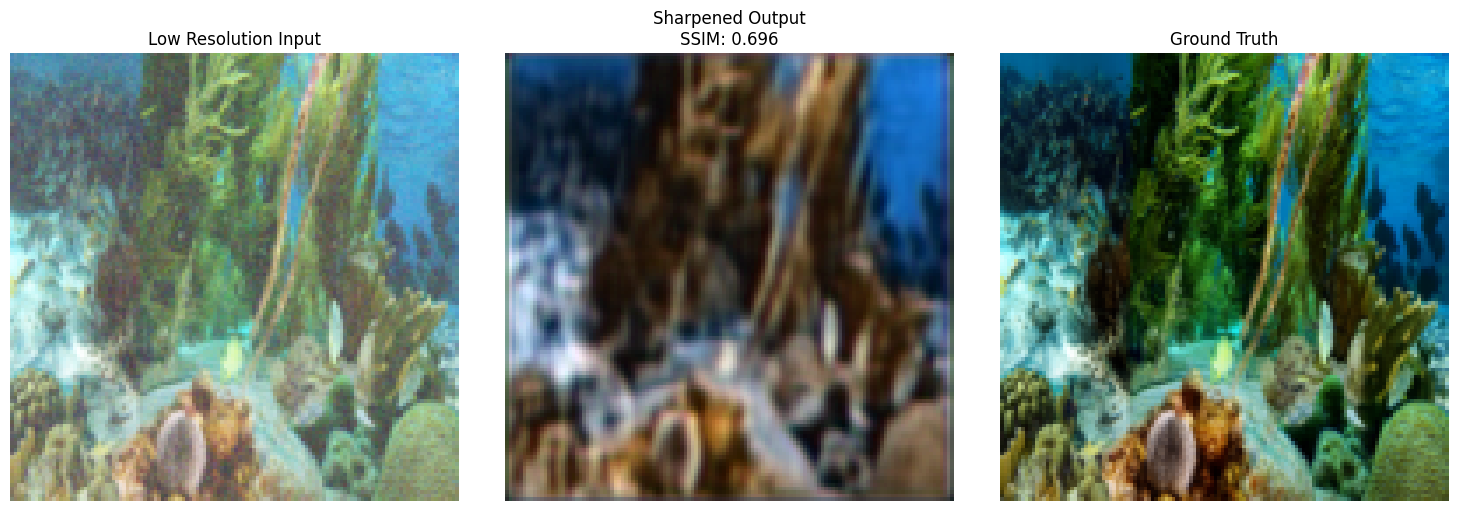

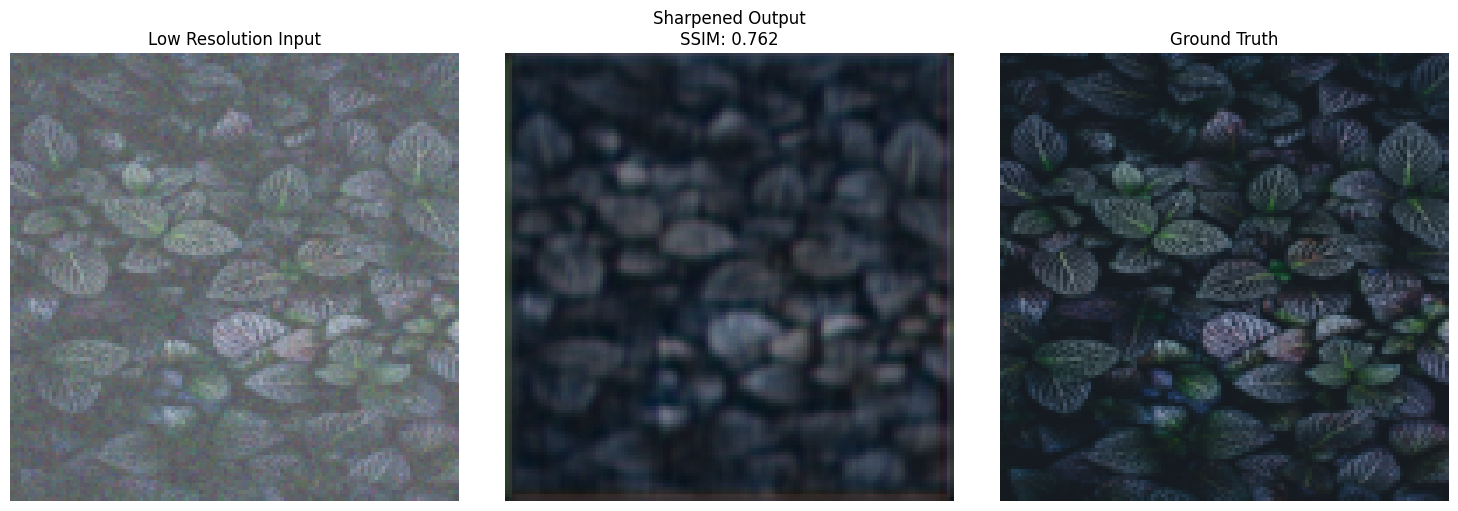

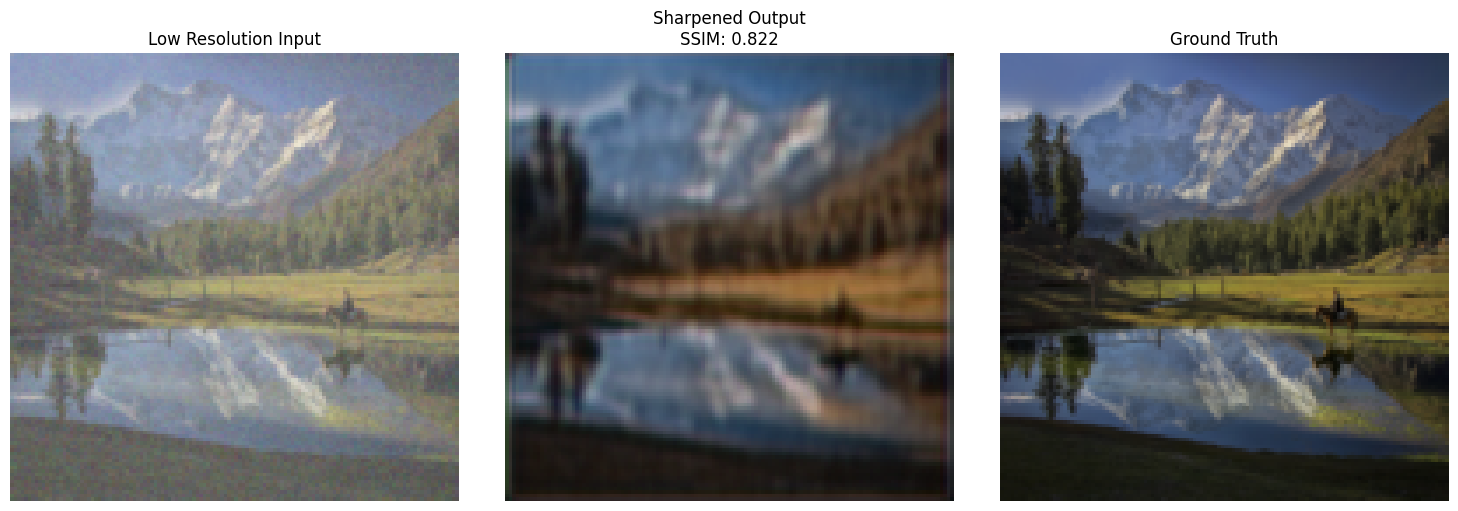

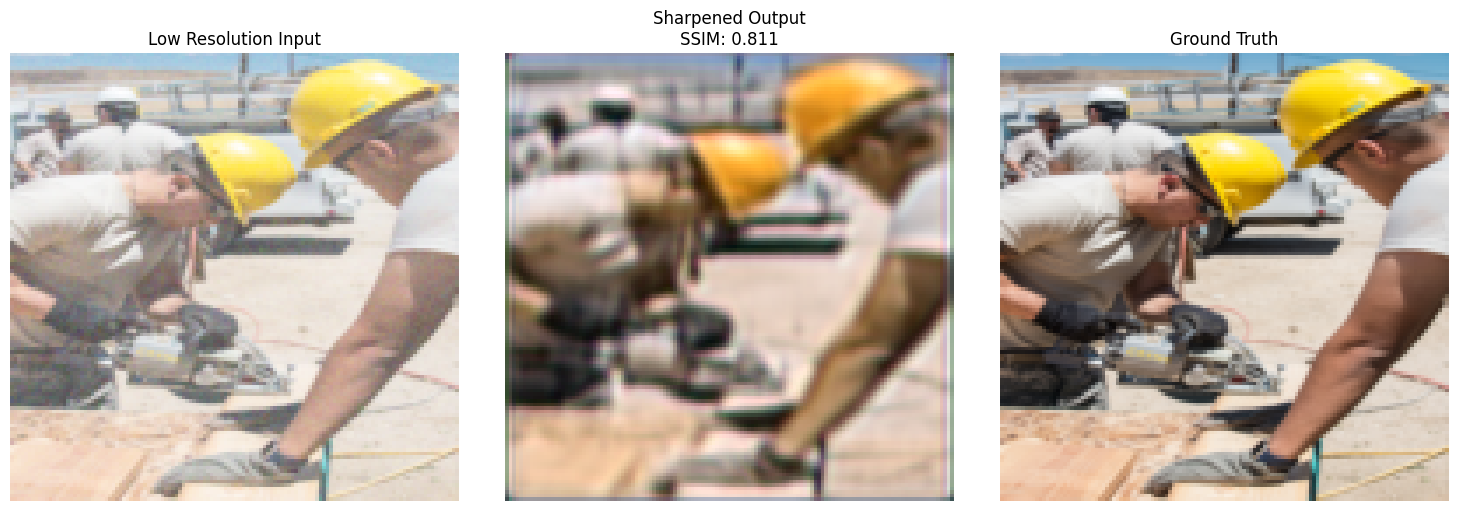

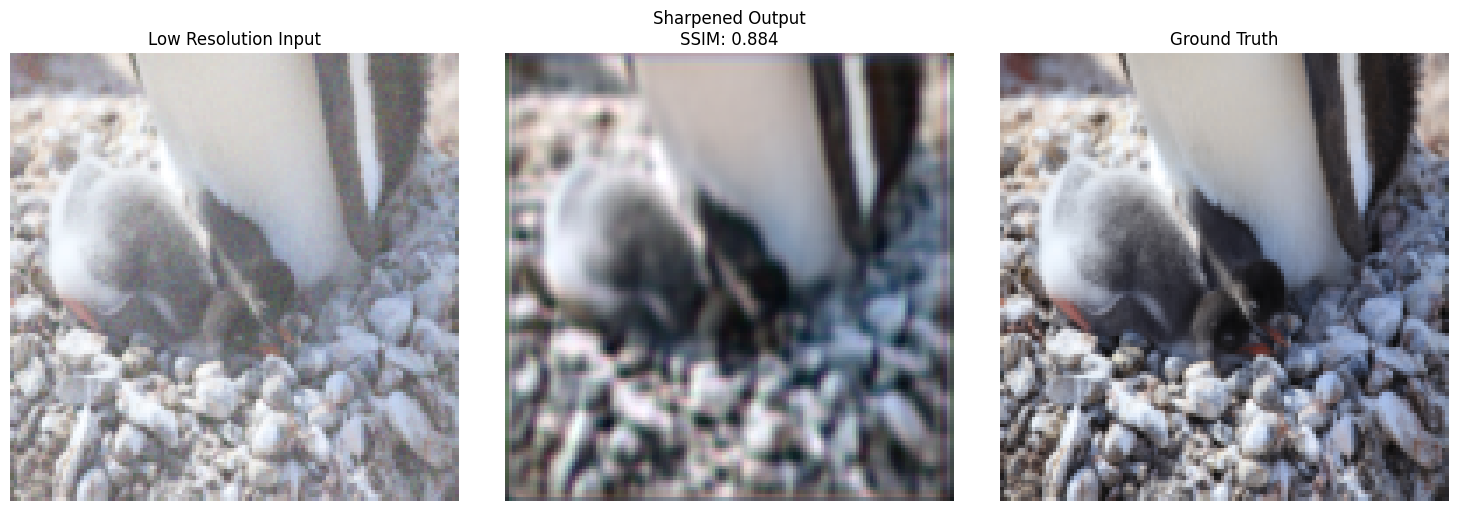

Average SSIM Score: 0.795


In [ ]:
dataset = SharpeningDataset(HR_DIR, LR_DIR, IMG_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset size: {len(dataset)} images")

# Initialize models
teacher = TeacherCNN().to(DEVICE)
student = StudentCNN().to(DEVICE)

# Train teacher first
train_teacher(teacher, dataloader, epochs=8)

# Train student with knowledge distillation
train_student_with_kd(student, teacher, dataloader, epochs=EPOCHS)

# ------------------------
# EVALUATION
# ------------------------
def evaluate_model(model, test_loader, num_samples=5):
    model.eval()
    ssim_scores = []

    with torch.no_grad():
        for i, (lr_batch, hr_batch) in enumerate(test_loader):
            if i >= num_samples:
                break

            lr_batch, hr_batch = lr_batch.to(DEVICE), hr_batch.to(DEVICE)
            output = model(lr_batch)

            # Convert to numpy for SSIM calculation
            for j in range(lr_batch.size(0)):
                if len(ssim_scores) >= num_samples:
                    break

                pred_np = output[j].cpu().permute(1, 2, 0).numpy()
                gt_np = hr_batch[j].cpu().permute(1, 2, 0).numpy()
                lr_np = lr_batch[j].cpu().permute(1, 2, 0).numpy()

                # Clip values to [0, 1]
                pred_np = np.clip(pred_np, 0, 1)
                gt_np = np.clip(gt_np, 0, 1)
                lr_np = np.clip(lr_np, 0, 1)

                # Calculate SSIM
                score = ssim(gt_np, pred_np, channel_axis=2, win_size=7, data_range=1.0)
                ssim_scores.append(score)

                # Display results
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(lr_np)
                plt.title("Low Resolution Input")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(pred_np)
                plt.title(f"Sharpened Output\nSSIM: {score:.3f}")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(gt_np)
                plt.title("Ground Truth")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

    avg_ssim = np.mean(ssim_scores)
    print(f"Average SSIM Score: {avg_ssim:.3f}")
    return avg_ssim

# Evaluate the trained student model
avg_ssim = evaluate_model(student, dataloader, num_samples=5)

In [ ]:
torch.save({
    'teacher_state_dict': teacher.state_dict(),
    'student_state_dict': student.state_dict(),
    'avg_ssim': avg_ssim
}, "/kaggle/working/sharpening_models.pth")

print(f"Models saved! Final SSIM: {avg_ssim:.3f}")

Models saved! Final SSIM: 0.795
